In [187]:
import matplotlib.pyplot as plt
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO


from akita_utils import *
import pysam
import h5py
genome_open = pysam.Fastafile('/project/fudenber_735/genomes/mm10/mm10.fa')

In [188]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import tensorflow as tf
print(tf.__version__)

import pysam
from basenji import dataset, seqnn, dna_io,stream
head_i = 1 #mouse
model_num = 1 #which fold to use


#base_dir = '/project/fudenber_735/backup/DNN_HiC/human-mouse_5-16-21/'
#model_dir = base_dir+"/f"+str(model_num)+"_c0/train/"

base_dir = '/project/fudenber_735/tensorflow_models/akita/v2/models/'
model_dir = base_dir+"/f"+str(model_num)+"c0/train/"
model_file  = model_dir+'/model'+str(head_i)+'_best.h5'


# model_dir = '/home1/fudenber/repositories/basenji/manuscripts/akita/'
# model_file = model_dir+'/model_best.h5'

params_file = model_dir+'/params.json'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']
seq_length = params_model['seq_length']
params_model['verbose'] = False
seqnn_model = seqnn.SeqNN(params_model)
print('built')
seqnn_model.restore(model_file, head_i=head_i)
print('restored')

hic_diags = params_model['diagonal_offset']
try:
    target_crop = params_model['trunk'][-2]['cropping']
except:
    target_crop = params_model['target_crop']
target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags)* ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size,2)
target_map_size, target_length_cropped, triu_tup[0].shape

2.6.2
built
restored


(512, 130305, (130305,))

In [189]:
akita_XL_dir = '/home1/fudenber/projects/akita_XL_2022/'
df_model1_perm = h5_to_df(akita_XL_dir+'permute_boundaries_motifs_ctcf_mm10_model1/scd.h5')
df_model7_perm = h5_to_df(akita_XL_dir+'permute_boundaries_motifs_ctcf_mm10_model7/scd.h5')
df = df_model1_perm.copy()
df['SCD'] = .5* (df_model1_perm['SCD'].values+df_model7_perm['SCD'].values)
df['INS-64'] = .5* (df_model1_perm['INS-64'].values+df_model7_perm['INS-64'].values)
df['span'] = df['span'].str.decode('utf8')
df.shape

orig 26544 filt 26515
29 duplicates removed
orig 26544 filt 26515
29 duplicates removed


(26515, 28)

In [190]:
## append scores for full mut and all ctcf mut to table
score_10k = np.zeros((len(df),))
score_all_ctcf = np.zeros((len(df),))
for i in np.unique(df['boundary_index'].values):
    if np.mod(i,1000)==0: print(i)
    inds = df['boundary_index'].values== i 
    df_boundary = df.iloc[inds]
    score_10k[inds] = df_boundary.iloc[-1]['SCD']
    if len(df_boundary)> 2:
        score_all_ctcf[inds] = df_boundary.iloc[-2]['SCD']
df['score_all_ctcf']= score_all_ctcf
df['score_10k']= score_10k


0
1000
2000
3000
4000


In [184]:
# considering only single ctcf mutations 
# require that they fall in an overall boundary that has some saliency
# TODO: also require that the neighboring bins don't have a more salient boundary?
# suffix _2 means _motif
sites = df.iloc[ (df['strand_2'].values != 'nan') *
                 (df['score_all_ctcf'].values > 5)
                ].copy()

# extracting start/end of motif from span
sites  = pd.concat([
                sites, 
                sites['span'].str.split('-', expand=True).astype(int).rename(columns={0:'start_2',1:'end_2'}).copy()],axis=1)
sites.reset_index(inplace=True,drop=True)

In [ ]:
# require that sites don't overlap rmsk !
# this is important for sineB2 in mice, maybe other things as well

rmsk_cols = pd.read_csv(StringIO('bin	swScore	milliDiv	milliDel	milliIns	genoName	genoStart	genoEnd	genoLeft	strand	repName	repClass	repFamily	repStart	repEnd	repLeft	id'),sep= '\t')
rmsk = pd.read_table('/project/fudenber_735/genomes/mm10/database/rmsk.txt.gz', names=rmsk_cols.keys())
rmsk.rename(columns={'genoName':'chrom','genoStart':'start','genoEnd':'end'}, inplace=True)
                     
sites = bioframe.count_overlaps(
                    sites, 
                    rmsk[['chrom','start','end']], cols1=['chrom','start_2','end_2'])
sites = sites.iloc[sites['count'].values==0]
sites.reset_index(inplace=True,drop=True)
if sites.duplicated().sum() > 0: 
    raise ValueError("no duplicates allowed")
    
sites['count'].sum(), (sites['count']==0).sum(), len(df), len(sites)

In [ ]:
plt.figure(figsize=(6,2))
plt.hist(sites['SCD'].values, np.linspace(-.5,100,200)  );
plt.semilogy();

In [ ]:
weak_thresh_pct = 1 # don't use sites weaker than this, might be artifacts
weak_num = 500 
strong_thresh_pct = 99 # don't use sites weaker than this, might be artifacts
strong_num = 500 

value_key = 'SCD'
strong_thresh = np.percentile(sites[value_key].values,strong_thresh_pct)
weak_thresh = np.percentile(sites[value_key].values,weak_thresh_pct)

weak_sites   = sites.loc[ sites[value_key] > weak_thresh  ].copy().sort_values(value_key)[:weak_num]
strong_sites = sites.loc[ sites[value_key] < strong_thresh  ].copy().sort_values(value_key)[-strong_num:][::-1]

In [ ]:
weak_sites.reset_index(inplace=True,drop=True)
strong_sites.reset_index(inplace=True,drop=True)

In [15]:
background_file = 'background_seqs.fa'
background_seqs = []
with open(background_file,'r') as f:
  for line in f.readlines():
    if '>' in line: continue
    background_seqs.append(dna_io.dna_1hot(line.strip())) 


In [157]:
site_df =  pd.concat([strong_sites[:5].copy(),weak_sites[:5].copy()])
seq_coords_df = site_df[['chrom','start_2','end_2','strand_2','SCD']].copy().rename(
    columns={'start_2':'start','end_2':'end','strand_2':'strand', 'SCD':'genomic_SCD'})
seq_coords_df.reset_index(inplace=True)#, drop=True)
seq_coords_df = bioframe.expand(seq_coords_df,pad=60)

In [158]:
# seq_coords_df.to_csv('test.insert2.tsv', sep='\t', index=False) ## to generate a tsv file for the script akita_insert.py

In [159]:
s = seq_coords_df.iloc[0]
seq_1hot_motif = dna_io.dna_1hot(genome_open.fetch(s.chrom, s.start, s.end).upper())
insert_length = len(seq_1hot_motif)
spacer_bp = 0
num_inserts = 6
multi_insert_length = num_inserts * (insert_length+spacer_bp)

offsets = []
for i in range(num_inserts):
    offsets.append( seq_length//2 - multi_insert_length//2 + i * (insert_length+spacer_bp))
offsets, seq_length//2

([654943, 655082, 655221, 655360, 655499, 655638], 655360)

In [191]:
all_inserts = []
for s in seq_coords_df.itertuples():
  for background_seq in background_seqs[0:1]:
    seq_1hot = background_seq.copy()
    seq_1hot_motif = dna_io.dna_1hot(genome_open.fetch(s.chrom, s.start, s.end).upper())
    if s.strand == '-': seq_1hot_motif = dna_io.hot1_rc(seq_1hot_motif)
    insert_length = len(seq_1hot_motif)
    for offset in offsets:
       seq_1hot[offset:offset+insert_length] = seq_1hot_motif
    all_inserts.append(seq_1hot)  
all_inserts = np.array( all_inserts)

In [ ]:
## predict for each insertion
pred = seqnn_model.predict(all_inserts, batch_size=10)

0 [31.83 45.25 45.25 45.25 45.25 32.  ]
1 [23.53 32.   32.   32.   32.   32.  ]
2 [24.23 32.34 45.25 45.25 32.   32.  ]
3 [27.38 32.84 45.25 43.4  32.   32.  ]
4 [23.84 32.   35.44 32.7  32.   32.  ]
5 [8.01  8.055 8.    8.    8.    5.74 ]
6 [8.    8.    8.    8.    8.    5.656]
7 [8.    8.    8.    8.    8.    5.656]
8 [8.    8.    8.    8.    8.    5.656]
9 [8.    8.    8.    8.    8.    5.656]


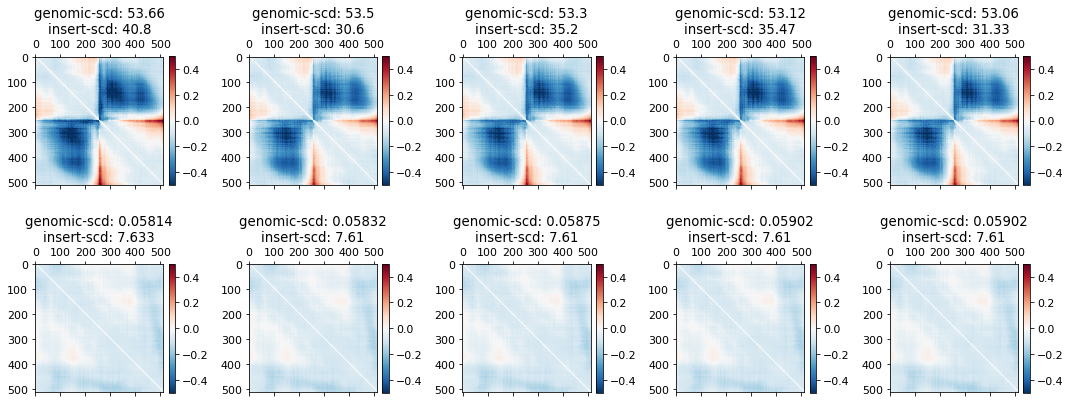

In [ ]:
plt.figure(figsize=(5*3,2*3))

target_ind = 0
vlim = .5
bin_mid = target_map_size//2
window = 50
for i in range(len(seq_coords_df)):
    insert_pred = pred[i]
    print(i, np.sqrt( (insert_pred**2).sum(axis=0)))

    plt.subplot(2,5, i+1)
    im = plt.matshow(
            from_upper_triu(  
            insert_pred[:,target_ind], target_map_size,hic_diags),
            vmin=-1*vlim, vmax=vlim, fignum=False,cmap='RdBu_r')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('genomic-scd: '+str(seq_coords_df['genomic_SCD'].values[i]) +'\n'+
              'insert-scd: '+str(  np.sqrt( (insert_pred**2).sum(axis=0)  ).mean() ) 
              ) 
    #plt.axis([ bin_mid  - window,bin_mid+window,bin_mid-window, bin_mid+window])
plt.tight_layout()
plt.show()